# Flower Image Classification
**Pytorch** implementation of an image classifier for identification of flower species with deep learning. It is trained on **102 flower categories** from [Oxford Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). To obtain higher accuracy of our model we take advantage of **transfer learning** with a **pretrained network**. 

The project is the final assigment for Udacity [PyTorch Scholarship Challenge](https://www.udacity.com/facebook-pytorch-scholarship).

This notebook is divided into **3 sections**:
* Data loading and preprocessing
* Building and training a model
* Using the model for inference



In [1]:
!unzip 'flower_data_with_test.zip'

Archive:  flower_data_with_test.zip
replace flower_data/test/1/image_06743.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Import Dependencies 

In [0]:
import torch, torchvision
from torch import nn, optim
from torchvision import models, transforms
from torch.optim import lr_scheduler

import numpy as np
import time
import json
import math

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available! Training on GPU.')
else:
    print('CUDA is not available. Training on CPU.')    

CUDA is available! Training on GPU.


## Load and Preprocess the Data
The dataset is split into three parts - **training**, **validation** and **test sets**. Training set is used to train a model, validation set to choose the right hyperparameters and test set to estimate final accuracy. Each set has already a structure needed by ImageFolder, for example: `train/class/image`


Images are **resized and cropped** to 224x224 pixels and **normalized** by mean \[0.485, 0.456, 0.406] and standard deviation \[0.229, 0.224, 0.225] (values for each color channel) as required by pretrained network.

In addition, training data is **augmented** by random resize, crop, rotation and horizontal flip transformations. 

In [0]:
data_dir = 'flower_data/'
phases = ['train', 'valid', 'test']
dirs = {phase: data_dir + phase for phase in phases}

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

batch_size = 16

# Define transforms
data_transforms = {
    'train' : transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
    ]),
    'valid' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
    ]),
    'test' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
    ])
}   

# Load the datasets
image_datasets = {
    phase: torchvision.datasets.ImageFolder(dirs[phase], 
           transform = data_transforms[phase]) for phase in phases}
   
# Prepare batches of data with DataLoaders
dataloaders = {
    phase: torch.utils.data.DataLoader(image_datasets[phase], 
         batch_size = batch_size, shuffle = True) for phase in phases}

# Get mapping from classes (folder names) to dataset indices (labels)
class_to_idx = dataloaders['test'].dataset.class_to_idx
idx_to_class = {class_to_idx[str(c)] : c for c in class_to_idx}

In [0]:
# Load flower names
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

### Visualize the Data
First, we display a few images of flowers with their names before training the network.

In [0]:
def unnormalize(image):
    """
    Transform an image back to original (unnormalized) values.
    
    :param image: numpy image to transform
    :return: transformed image
    """
    np_std = np.array(std).reshape(3, 1, 1)
    np_mean = np.array(mean).reshape(3, 1, 1)

    image = image * np_std + np_mean
    image = image.clip(0, 1)
    return image

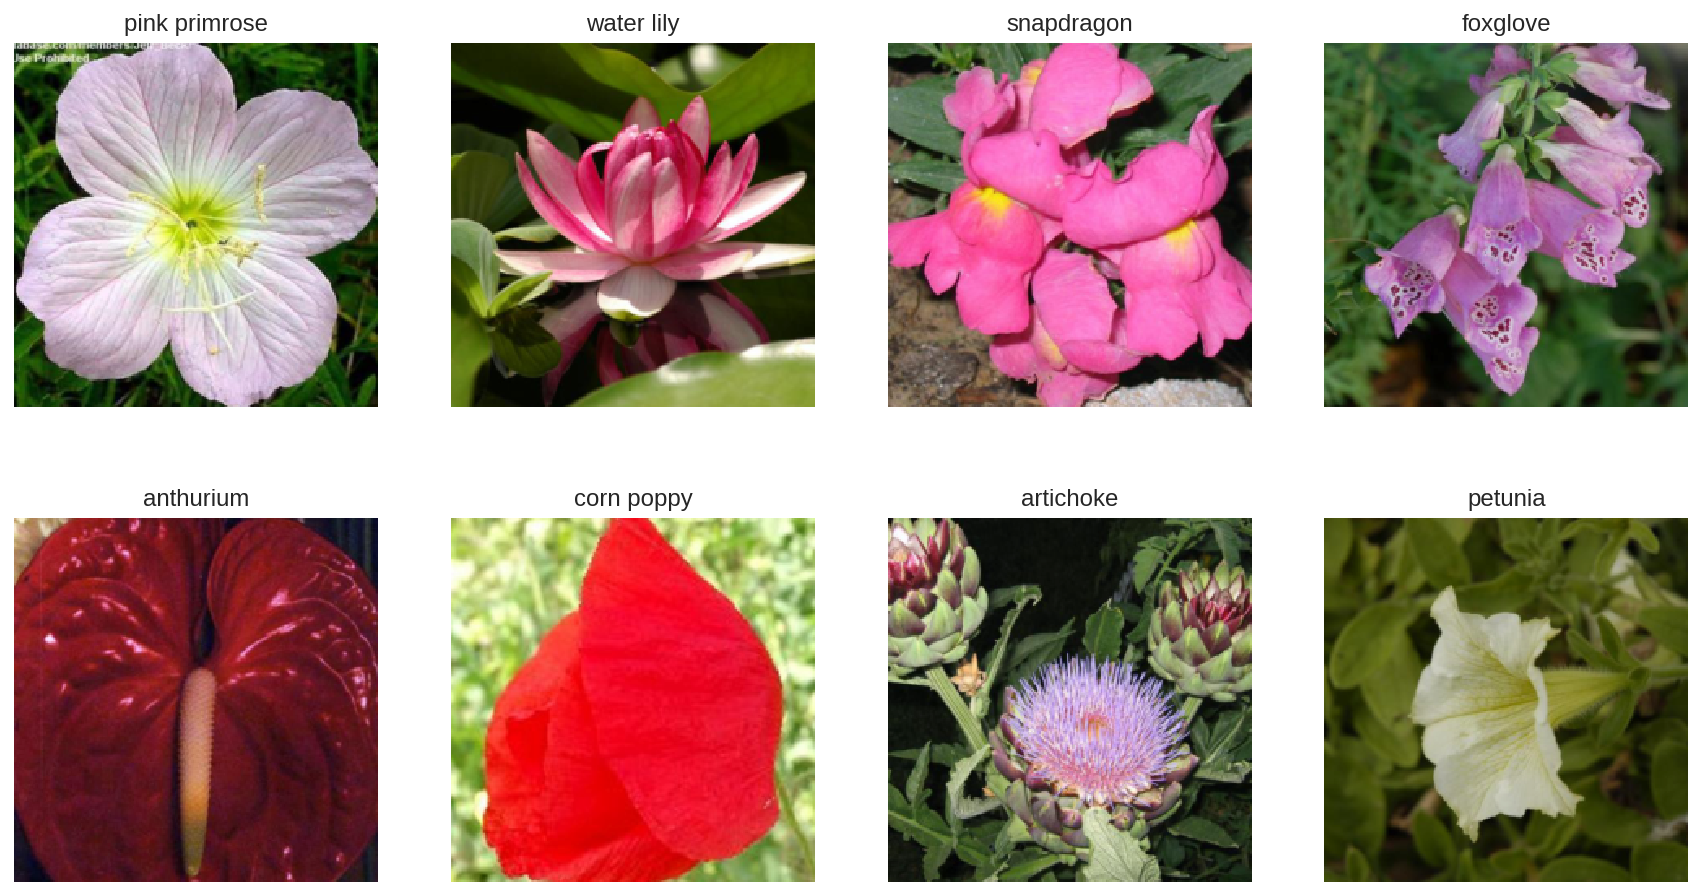

In [6]:
# Get a batch of images
images, labels = next(iter(dataloaders['valid']))

images = images.numpy()
num_of_images = 8
fig = plt.figure(figsize = (15, 8))  

# Display images and names of the flowers
for i in range(num_of_images):
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.imshow(unnormalize(images[i]).transpose((1, 2, 0)))
    
    # Get a class from a label
    c = idx_to_class[labels[i].item()]
    ax.set_title(cat_to_name[c])

## Build and Train the Neural Network
As our network architecture, we use **pretrained ResNet152** where we replace the fully connected layers with a newly **defined classifier** to be trained on our data.

In [0]:
def build_model(drop):
    """
    Builds and returns pretrained ResNet152 model with a new 2-layer classifier
    and LogSoftmax as the final activation function
    
    :param drop: dropout rate (0-1) between the two fully connected layers
    :return: pretrained ResNet152 model with a new classifier
    """
    
    # Load pretrained ResNet152
    model = models.resnet152(pretrained = True)
    
    # Define a new classifier
    classifier = nn.Sequential(nn.Linear(2048, 2048),
                           nn.Dropout(drop),
                           nn.ReLU(),
                           nn.Linear(2048, 102),
                           nn.LogSoftmax(dim=1))

    # Replace the old one
    model.fc = classifier
    
    # Move model to GPU
    if train_on_gpu:
        model.cuda()
        
    return model

In [0]:
def freeze_parameters(model, freeze_model, freeze_classifier):
    """
    Freezes/unfreezes parameters of a model for training. Frozen parameters will
    not train.
    
    :param model: model with parameters to freeze
    :param freeze_model: bool, if True, freezes the whole model
    :param freeze_classifier: bool, if True, freezes the classifier
    """
    
    # Freeze model
    for param in model.parameters():
        param.requires_grad = not freeze_model
        
    # Freeze classifier
    for param in model.fc.parameters():
        param.requires_grad = not freeze_classifier


We train the model for a number of epochs. After each epoch we compute **validation loss** on the validation dataset. If it **decreases**, we **save** the model parameters to a checkpoint.

In [0]:
def train_one_epoch(model, criterion, optimizer, loader):
    """
    Trains a model one epoch.
    
    :param model: model to train
    :param criterion: loss function (reduction='sum')
    :param optimizer: optimizer for optimization of model parameters
    :param loader: DataLoader with training data
    :return: average training loss
    """
    train_loss = 0;
    model.train()
    for images, labels in loader:
        optimizer.zero_grad()
        if (train_on_gpu):
            images, labels = images.cuda(), labels.cuda()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += float(loss)

        # Backpropagation and weight update
        loss.backward()
        optimizer.step()
        
    return train_loss / len(dataloaders['train'].dataset)

In [0]:
def compute_loss_and_n_correct(model, criterion, loader):
    """
    Computes loss and number of correctly classified examples of validation/test
    datataset.
    
    :param model: model to evaluate
    :param criterion: loss function (reduction='sum')
    :param loader: DataLoader with validation/test data
    :return: average loss and number of correctly classified examples
    """
    model.eval()
    loss = 0;
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            if (train_on_gpu):
                images, labels = images.cuda(), labels.cuda()

            # Forward pass
            outputs = model(images)
            loss += float(criterion(outputs, labels))
            
            # Compute number of correctly classified images
            _, preds = torch.max(outputs, 1)
            equals = preds == labels.data
            correct += torch.sum(equals.type(torch.FloatTensor))
            
    return loss / len(dataloaders['valid'].dataset), int(correct)

In [0]:
def save_parameters(model, epoch, loss, path):
    """
    Saves a checkpoint with state_dict of a model into a file.
    
    :param model: model to save
    :param epoch: epoch number
    :param loss: validation loss of the model
    :param path: path to save the checkpoint to
    """
    checkpoint = {
        'state_dict': model.state_dict(),
        'epoch': epoch,
        'loss': loss
    }
    torch.save(checkpoint, path)

In [0]:
def load_parameters(model, path):
    """
    Loads parameters into a model.
    
    :param model: model to load parameters into
    :param path: filepath of a checkpoint with saved parameters
    :return: epoch and minimal validation loss of the saved model
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    epoch = checkpoint['epoch']
    min_loss = checkpoint['loss']
    
    return epoch + 1, min_loss

In [0]:
def train(model, epochs, criterion, optimizer, scheduler, dataloaders
          save_path, load_path = None):
    """
    Trains a model.
    
    :param model: model to train
    :param epochs: number of epochs to train
    :param criterion: loss function (reduction='sum')
    :param optimizer: optimizer for optimization of model parameters
    :param scheduler: scheduler for decreasing the learning rate
    :param dataloaders: DataLoaders with training and validation datasets
    :param save_path: destination for saving a model
    :param load_path: path of a checkpoint with saved parameters of a model 
        to train further
    :return: training and validation losses and accuracies for each batch
    """
    
    if load_path is None:
        # Training from the beginning
        starting_epoch = 1
        min_loss = math.inf
    else:
        # Load data from checkpoint
        starting_epoch, min_loss = load_parameters(model, load_path)

    # Keep track of accuracy and training and validation loss
    train_losses, valid_losses, accuracies = [], [], []
    
    for epoch in range(starting_epoch, starting_epoch + epochs):
        start_time = time.time()     
        scheduler.step()
    
        # Train model
        train_loss = train_one_epoch(model, criterion, optimizer, 
                                     dataloaders['train'])
        
        # Validation
        valid_loss, correct = compute_loss_and_n_correct(model, criterion, 
                                                        dataloaders['valid'])
        
        accuracy = 100 * correct / len(dataloaders['valid'].dataset)
        print(('Epoch {}/{}, Training loss: {:.3f}, Validation loss: {:.3f}, ' \
               'Accuracy: {:.2f}%, Time: {:.0f} s').format(
                    epoch, epochs + starting_epoch - 1, train_loss, valid_loss, 
                    accuracy, time.time() - start_time))

        # Save model parameters if validation loss decreased
        if valid_loss < min_loss:
            min_loss = valid_loss
            save_parameters(model, epoch, valid_loss, save_path)

        # Save losses and accuracy
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accuracies.append(accuracy)
        
    return train_losses, valid_losses, accuracies

### Define Model Hyperparameters

In [0]:
# Hyperparameters for training
epochs = 12
drop = 0.1
lr = 1e-03

# Hyperparameters for fine-tunig
epochs_ft = 12
lr_ft = 1e-05

# Hyperparameters for the scheduler
step = 5
gamma = 0.2

### Define Optimizer, Loss and Scheduler
We use Adam optimizer, NLLLoss and StepLR scheduler with hyperparameters defined above.

In [0]:
def get_optimizer(model, lr):
    """
    Returns an optimizer for all unfrozen parameters of a model with a learning 
    rate.
    
    :param model: model to optimize
    :param lr: learning rate 
    :return: optimizer
    """
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    return optim.Adam(parameters, lr)

In [0]:
model = build_model(drop)
optimizer = get_optimizer(model, lr)
criterion = nn.NLLLoss(reduction='sum')
scheduler = lr_scheduler.StepLR(optimizer, step, gamma)

### Train the Model
First, we freeze the CNN part of the network and train **only the classifier**.

In [17]:
checkpoint_path = 'checkpoint.pth'

freeze_parameters(model, freeze_model = True, freeze_classifier = False)
model, epochs, criterion, optimizer, scheduler, dataloaders
          save_path, load_path = None
train_losses, valid_losses, accuracies = train(
    model, epochs, criterion, optimizer, scheduler, dataloaders, 
    checkpoint_path)

Epoch 1/12, Training loss: 2.942, Validation loss: 1.213, Accuracy: 68.58%, Time: 223 s
Epoch 2/12, Training loss: 1.367, Validation loss: 0.633, Accuracy: 83.37%, Time: 223 s
Epoch 3/12, Training loss: 1.071, Validation loss: 0.545, Accuracy: 85.45%, Time: 224 s
Epoch 4/12, Training loss: 0.925, Validation loss: 0.455, Accuracy: 87.16%, Time: 224 s
Epoch 5/12, Training loss: 0.878, Validation loss: 0.342, Accuracy: 90.83%, Time: 224 s
Epoch 6/12, Training loss: 0.644, Validation loss: 0.293, Accuracy: 92.05%, Time: 224 s
Epoch 7/12, Training loss: 0.596, Validation loss: 0.278, Accuracy: 93.52%, Time: 224 s
Epoch 8/12, Training loss: 0.625, Validation loss: 0.272, Accuracy: 93.03%, Time: 224 s
Epoch 9/12, Training loss: 0.606, Validation loss: 0.278, Accuracy: 93.15%, Time: 224 s
Epoch 10/12, Training loss: 0.576, Validation loss: 0.280, Accuracy: 92.54%, Time: 224 s
Epoch 11/12, Training loss: 0.544, Validation loss: 0.256, Accuracy: 93.52%, Time: 224 s
Epoch 12/12, Training loss: 0.

When the classifier is trained, we can unfreeze the CNN part and **fine-tune** the whole network to get better accuracy. We should use much **lower learning rate**.

In [18]:
freeze_parameters(model, freeze_model = False, freeze_classifier = False)
optimizer_ft = get_optimizer(model, lr_ft)
train_losses_ft, valid_losses_ft, accuracies_ft = train(
    model, epochs_ft, criterion, optimizer_ft, scheduler, dataloaders,
    checkpoint_path, checkpoint_path)

Epoch 12/23, Training loss: 0.480, Validation loss: 0.188, Accuracy: 95.35%, Time: 516 s
Epoch 13/23, Training loss: 0.364, Validation loss: 0.148, Accuracy: 96.33%, Time: 516 s
Epoch 14/23, Training loss: 0.315, Validation loss: 0.115, Accuracy: 97.56%, Time: 517 s
Epoch 15/23, Training loss: 0.282, Validation loss: 0.103, Accuracy: 97.92%, Time: 516 s
Epoch 16/23, Training loss: 0.252, Validation loss: 0.093, Accuracy: 97.80%, Time: 516 s
Epoch 17/23, Training loss: 0.231, Validation loss: 0.106, Accuracy: 97.80%, Time: 516 s
Epoch 18/23, Training loss: 0.213, Validation loss: 0.099, Accuracy: 97.31%, Time: 516 s
Epoch 19/23, Training loss: 0.224, Validation loss: 0.104, Accuracy: 97.92%, Time: 516 s
Epoch 20/23, Training loss: 0.186, Validation loss: 0.095, Accuracy: 97.68%, Time: 516 s
Epoch 21/23, Training loss: 0.175, Validation loss: 0.091, Accuracy: 98.17%, Time: 517 s
Epoch 22/23, Training loss: 0.165, Validation loss: 0.080, Accuracy: 98.53%, Time: 518 s
Epoch 23/23, Training

In [0]:
# Load the best model
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

### Evaluate the Model
To better **visualize** the training process and to find out if the model is **overfitting or underfitting**, it's useful to **plot** model **loss** and **accuracy** throughout the training. First, we display data from the training of the **classifier**.

In [0]:
def plot_graphs(epoch_labels, train_losses, valid_losses, accuracies):
    """
    Plots losses and accuracy graphs.
    
    :param epoch_labels: labels for x-axis
    :param train_losses: values of training loss
    :param valid_losses: values of validation loss
    :param accuracies: values of accuracy
    """
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot losses
    ax1.plot(epoch_labels, train_losses, label = 'Training loss')
    ax1.plot(epoch_labels, valid_losses, label = 'Validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_title('Training and Validation loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(epoch_labels, accuracies, color = 'brown', label = 'Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_title('Accuracy')
    ax2.legend();

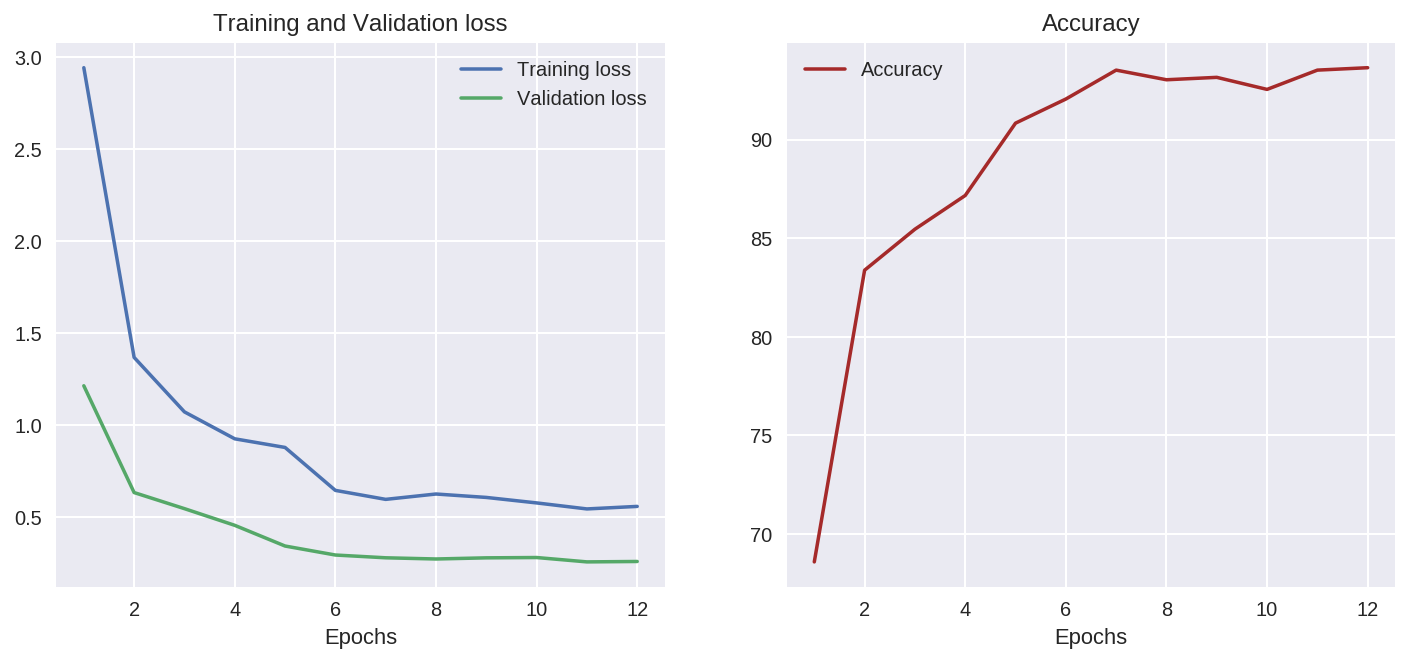

In [21]:
epoch_labels = np.arange(1, epochs + 1, 1)
plot_graphs(epoch_labels, train_losses, valid_losses, accuracies)

And then also graphs obtained during **fine-tuning** of the whole model.

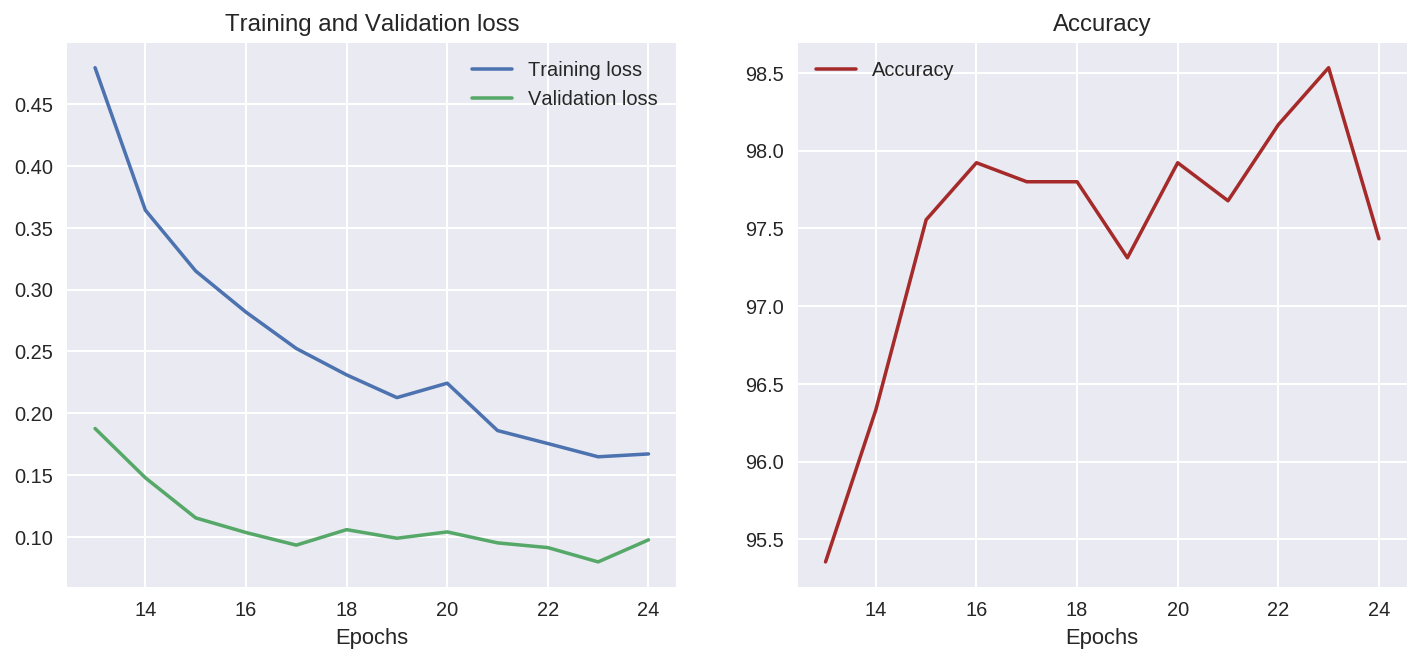

In [22]:
epoch_labels_ft = np.arange(epochs + 1, epochs + epochs_ft + 1, 1)
plot_graphs(epoch_labels_ft, train_losses_ft, valid_losses_ft, accuracies_ft)

Compute **accuracy** on **test** data. The model hasn't seen the test data yet, therefore this accuracy estimates **real-world** performance.

In [23]:
test_loss, correct = compute_loss_and_n_correct(model, criterion, 
                                               dataloaders['test'])

print('Test Accuracy: {:.2f} ({}/{})'.format(
        100 * correct / len(dataloaders['test'].dataset),
        correct, len(dataloaders['test'].dataset)))

Test Accuracy: 98.05 (803/819)


The training of the model went quite well, the **test accuracy is over 98% after just 22 epochs**. From the graphs we don't see any overfitting, both training and validation loss were still mostly decreasing and we could probably train the model for a couple epochs more to get better results. 

Training loss is higher then validation loss due to dropout and data augmantation. 

## Inference
With the model trained, we can use it for inference. That means **predicting** a flower class of new images.

First we need to **preprocess** the input image the same way as the validation/testing images, i. e. by the corresponding transform, then we predict **top k** most probable classes.

In [0]:
def preprocess_image(image_path):
    """
    Loads and preprocesses an image.
    
    :param image_path: path of an image
    :return: preprocessed image tensor
    """
    image = Image.open(image_path)
    tensor = data_transforms['test'](image)
    
    return tensor

In [0]:
def predict(image, model, topk = 5):
    """
    Returns topk probabilities and class indices of an image predicted by 
    a model.
        
    :param image: image tensor to predict flower class
    :param model: model for the prediction
    :param topk: number of top outputs to return
    :returns: probabilities and classes of topk predictions as numpy array
    """
    model.eval()
    
    if train_on_gpu:
        image = image.cuda()
        
    with torch.no_grad():
        # If predicting only one image, add a dimension for batch size
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        output = model(image)
        ps = torch.exp(output)
        probs, class_id = ps.topk(topk, dim=1)
    
    return probs.cpu().squeeze().numpy(), class_id.cpu().squeeze().numpy()

An **example** how to predict a flower class.

Classifying: pink primrose
Predicted:
  pink primrose 98.12
  watercress 0.83
  mallow 0.38
  balloon flower 0.23
  buttercup 0.17


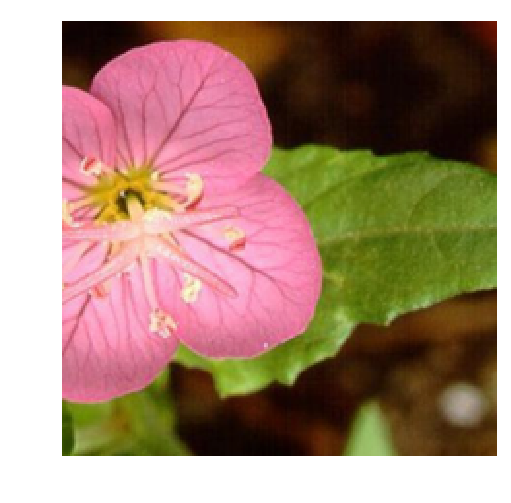

In [26]:
path = 'flower_data/test/1/image_06760.jpg'
print('Classifying: {}'.format(cat_to_name['1']))

k = 5
# Preprocess image
image = preprocess_image(path)

# Predict classes
probs, classes_idx = predict(image, model, k)

print('Predicted:')
for i in range(k):
    # Convert class index to class name and then to flower name
    name = cat_to_name[idx_to_class[classes_idx[i]]]
    print('  {} {:.2f}'.format(name, 100 * probs[i]))
    
plt.imshow(unnormalize(image.numpy()).transpose((1, 2, 0)))
plt.axis('off');

### Sanity Check
Visualize outputs of the algorithm for a few images from a batch to make sure they **make sense**.

In [0]:
# Get a batch of images
images, labels = next(iter(dataloaders['test']))
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

# Predict classes
probs, classes_idx = predict(images, model)

images = images.cpu().numpy() 
labels = labels.cpu().numpy()

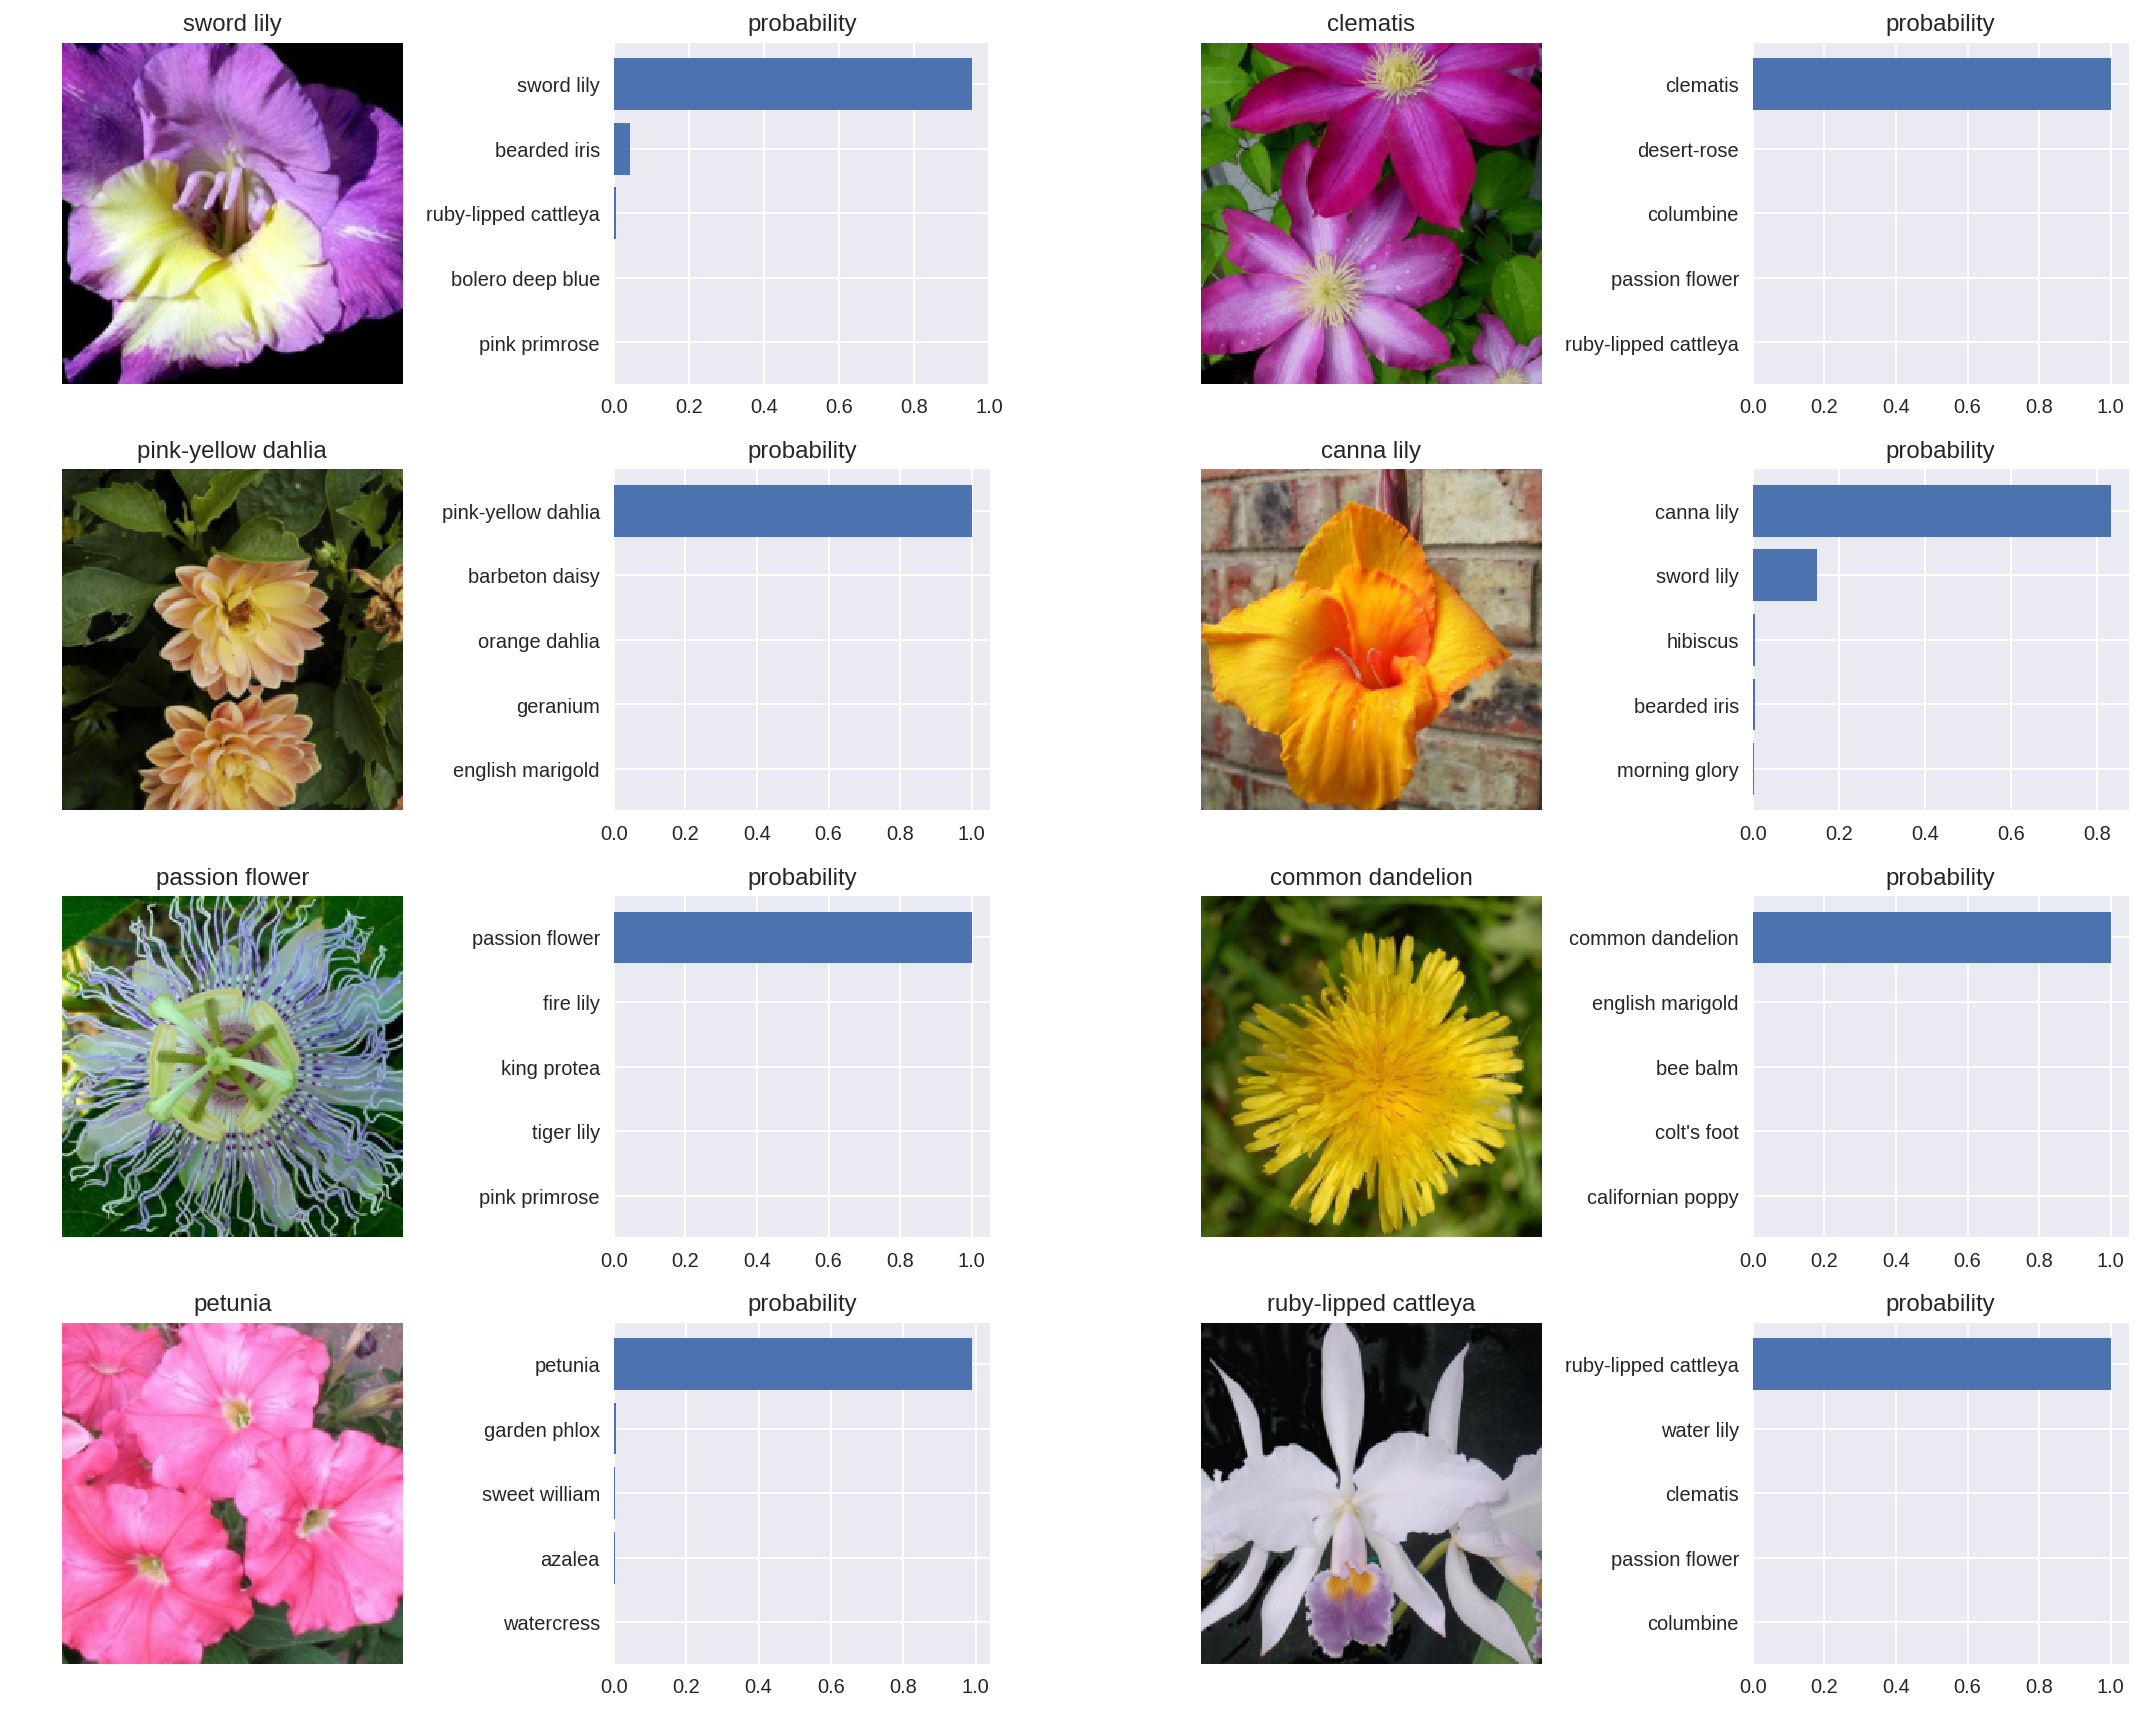

In [35]:
# Visualize results
num_of_images = 8
fig, ax = plt.subplots(4, 4, figsize=(15, 12))

for i in range(num_of_images):

    plt.sca(ax[(2*i)//4,(2*i)%4])
    plt.imshow(unnormalize(images[i]).transpose((1, 2, 0)))
    plt.title(cat_to_name[idx_to_class[labels[i]]])
    plt.axis('off')
    
    names = [cat_to_name[idx_to_class[c.item()]] for c in classes_idx[i]]
    y_pos = np.arange(len(names))
    
    plt.sca(ax[(2*i+1)//4,(2*i+1)%4])
    plt.barh(y_pos, probs[i,::-1], align='center', alpha=1)
    plt.yticks(y_pos, names[::-1])
    plt.title('probability')

    fig.tight_layout()
    
plt.show()  